In [1]:
# Jupyter Notebook

# Importando as bibliotecas necessárias
import os
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import math
import EcoSimpy



# Configurações iniciais
sns.set_theme(style="whitegrid")
pd.options.mode.chained_assignment = None  # Para evitar warnings de cópias de DataFrame

# Configurando os diretórios
input_dir = Path("runs")
output_dir = Path("results")
output_dir.mkdir(exist_ok=True)





/home/rivero/.venv/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Execução da Simulação

In [2]:
def main():
    # Activate virtual environment (if needed, adjust path accordingly)
    venv_path = os.path.join(os.getcwd(), "venv")
    if os.path.exists(venv_path):
        activate_script = os.path.join(venv_path, "bin", "activate_this.py")
        with open(activate_script) as f:
            exec(f.read(), {'__file__': activate_script})


    print("Current directory:", os.getcwd())


    config_json_file = "config.json"        

    # Get current directory as app_dir
    app_dir = os.getcwd()


    benchmark_sim = EcoSimpy.Simulation(app_dir,
                                        config_json_file,
                                        clean_run=True
                                        )
    

    benchmark_sim.execute_simulation()


if __name__ == "__main__":
    main()

Current directory: /home/rivero/Dropbox/Workspace_Current/Projects/Apps/EcoSimpy_dev/examples/benchmark


Scenario: Scenario1 Run nr.: 2: 100%|███████████| 60/60 [00:04<00:00, 14.41it/s]


Observer data saved to macro_model_Household_obs1_2025-09-08T17_08_.csv
Observer data saved to macro_model_CGFirm_obs1_2025-09-08T17_08_.csv


# Processar os dados de saída da simulação


In [3]:


output_dir.mkdir(exist_ok=True)

print(input_dir)

# Carregar arquivos Household
files = [f for f in os.listdir(input_dir) if "macro_model_Household" in f]
if files:
    Household = pd.read_csv(os.path.join(input_dir, files[0]))
    Household = Household.drop(columns=[col for col in ["run", "index_no"] if col in Household.columns])
else:
    Household = pd.DataFrame()

# Carregar arquivos CGFirm
files = [f for f in os.listdir(input_dir) if "macro_model_CGFirm" in f]
if files:
    CGFirm = pd.read_csv(os.path.join(input_dir, files[0]))
    CGFirm = CGFirm.drop(columns=[col for col in ["run", "index_no"] if col in CGFirm.columns])
else:
    CGFirm = pd.DataFrame()

# Gerar dataframes de médias e contagem de booleanos
if not Household.empty:
    household_means = Household.groupby("step").agg(
        {**{col: "mean" for col in Household.select_dtypes(include="number").columns if col != "step"},
            **{col: "sum" for col in Household.select_dtypes(include="bool").columns}}
    ).reset_index()
    household_means.to_csv(output_dir / "household_means.csv", index=False)
else:
    print("Nenhum dado Household encontrado.")

if not CGFirm.empty:
    cg_means = CGFirm.groupby("step").agg(
        {**{col: "mean" for col in CGFirm.select_dtypes(include="number").columns if col != "step"},
            **{col: "sum" for col in CGFirm.select_dtypes(include="bool").columns}}
    ).reset_index()
    cg_means.to_csv(output_dir / "cg_means.csv", index=False)
else:
    print("Nenhum dado CGFirm encontrado.")

print("Processamento concluído.")




runs
Processamento concluído.


## Análise do Resultado

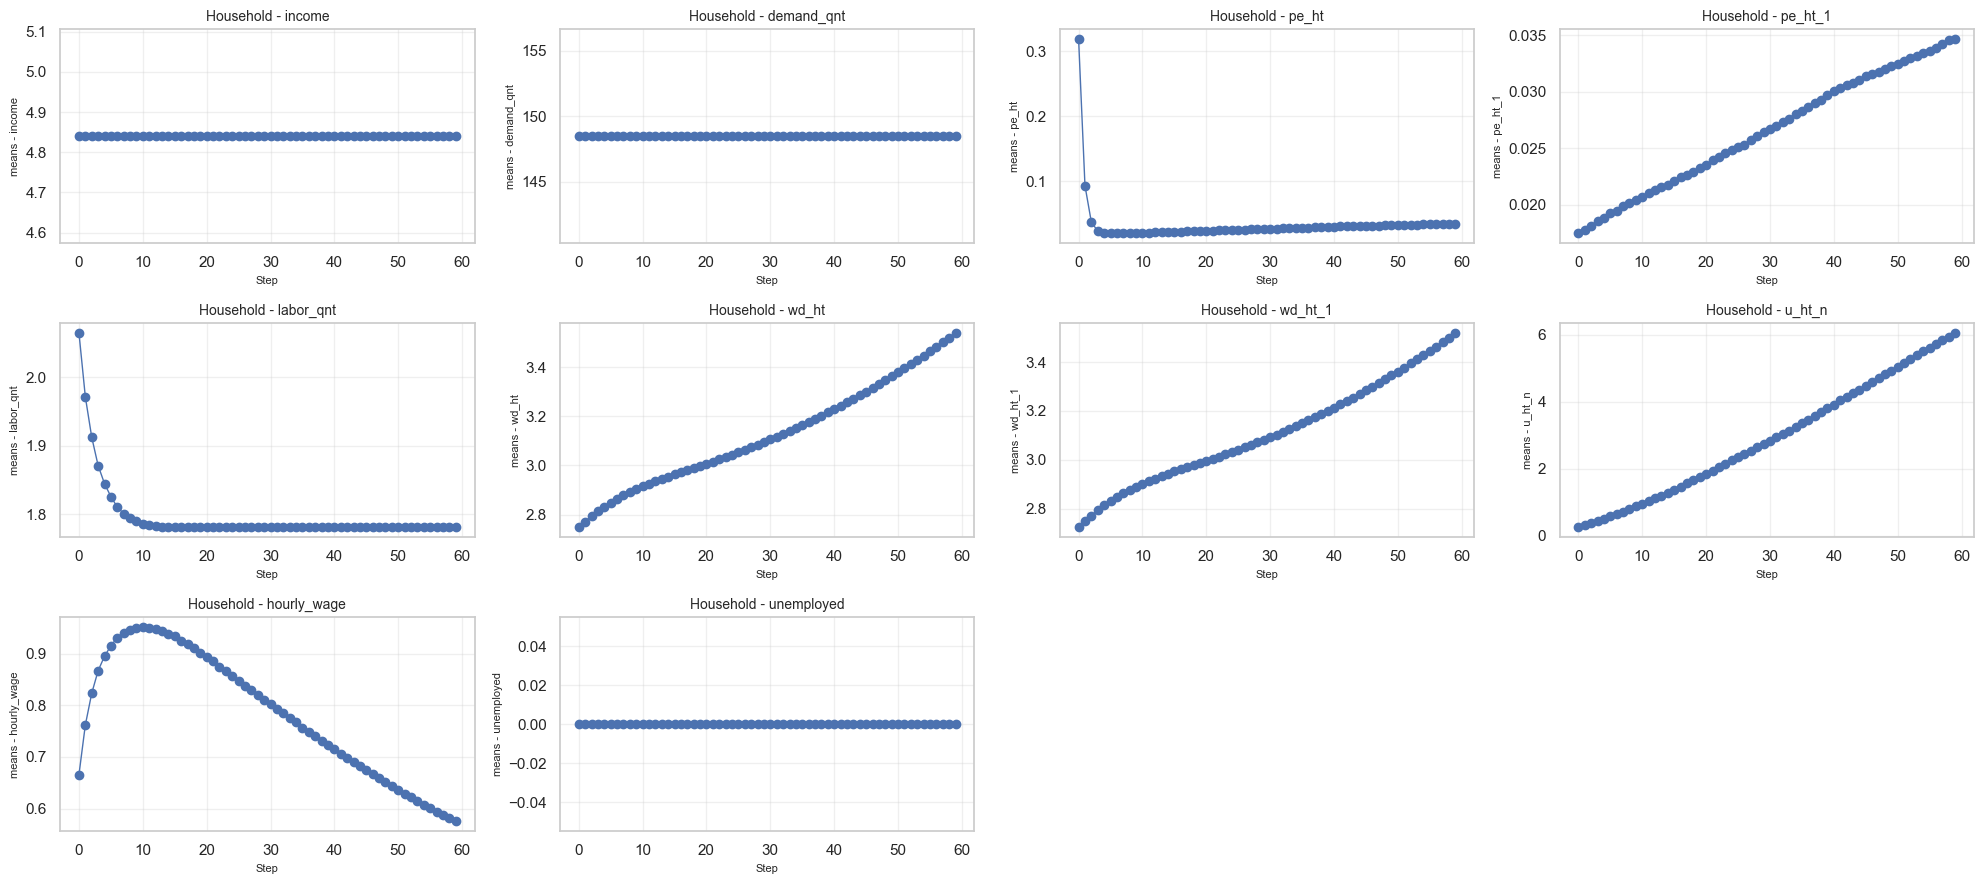

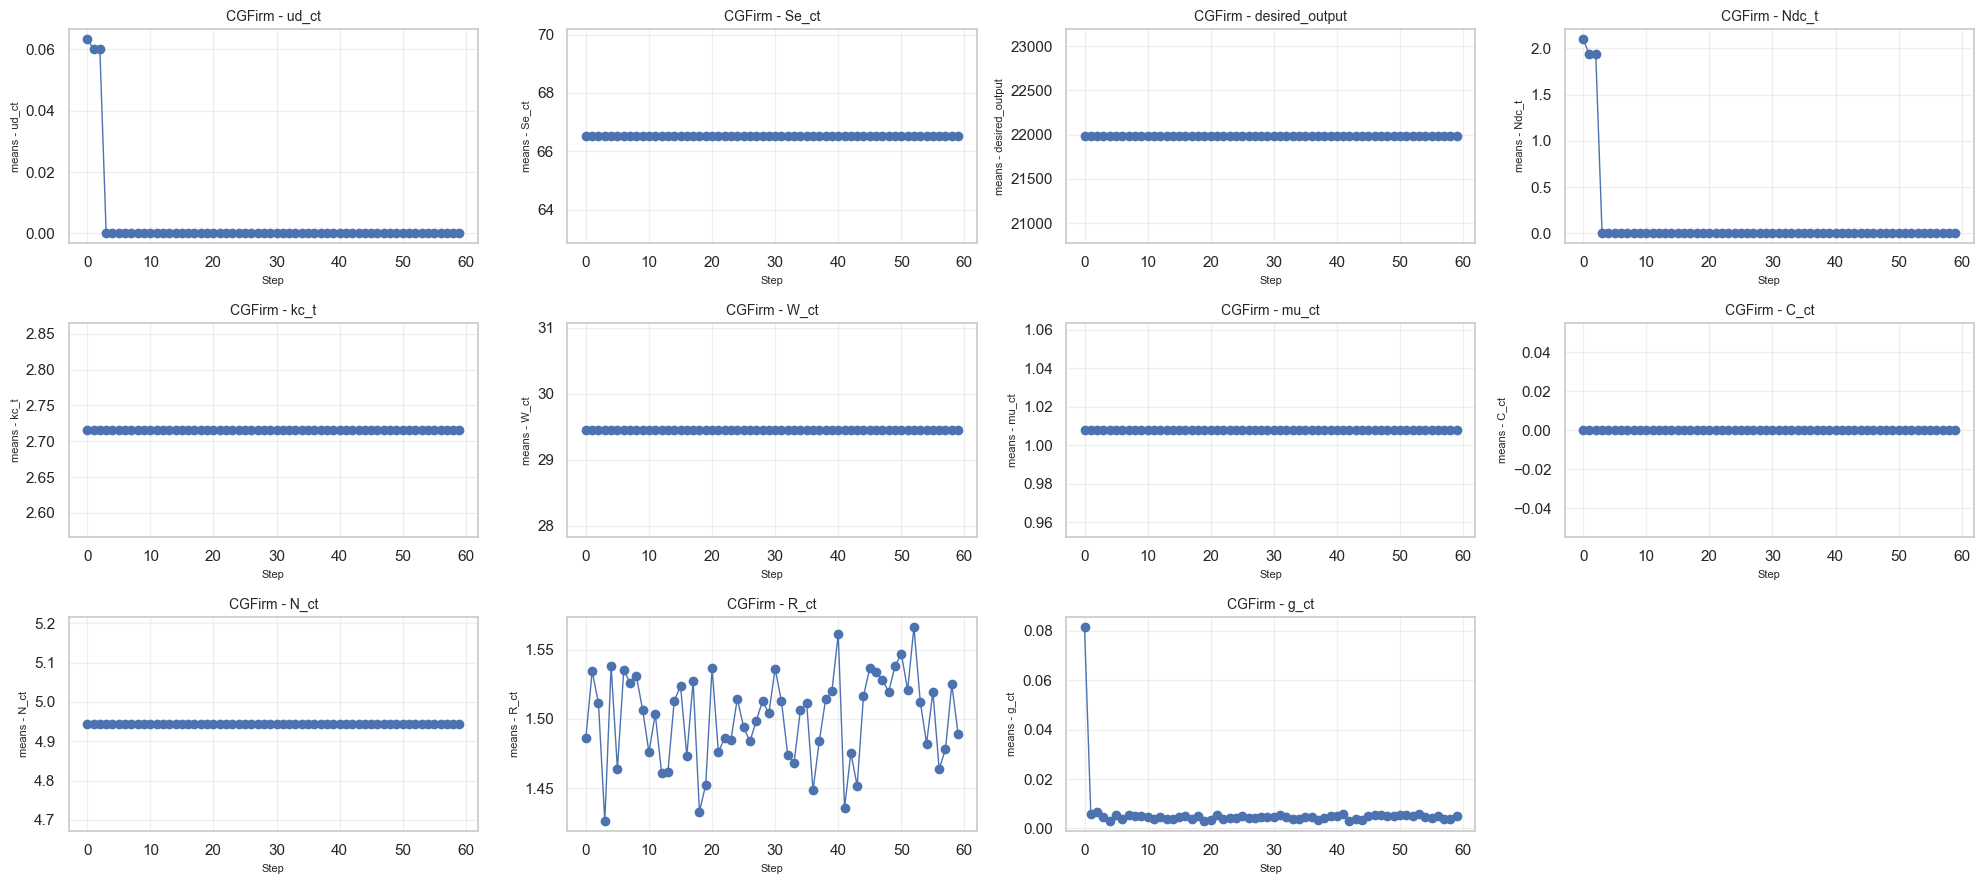

In [4]:
household_means_path = output_dir / "household_means.csv"
cg_means_path = output_dir / "cg_means.csv"

if household_means_path.exists():
    household_means = pd.read_csv(household_means_path)
else:
    household_means = None
    print("Arquivo household_means.csv não encontrado.")

if cg_means_path.exists():
    cg_means = pd.read_csv(cg_means_path)
else:
    cg_means = None
    print("Arquivo cg_means.csv não encontrado.")

def plot_grid(df, title_prefix, ncol=4):
    if df is None:
        return
    cols = [col for col in df.columns if col != "step"]
    n = len(cols)
    nrow = math.ceil(n / ncol)
    fig, axes = plt.subplots(nrow, ncol, figsize=(5*ncol, 3*nrow), squeeze=False)
    for idx, var in enumerate(cols):
        ax = axes[idx // ncol][idx % ncol]
        ax.plot(df["step"], df[var], marker="o", linewidth=1)
        ax.set_title(f"{title_prefix} - {var}", fontsize=10)
        ax.set_xlabel("Step", fontsize=8)
        ax.set_ylabel(f"means - {var}", fontsize=8)
        ax.grid(True, alpha=0.3)
    for idx in range(n, nrow * ncol):
        fig.delaxes(axes[idx // ncol][idx % ncol])
    plt.tight_layout()
    plt.show()

plot_grid(household_means, "Household", ncol=4)
plot_grid(cg_means, "CGFirm", ncol=4)
